# Evaluating the dilution hypothesis using ADMIXTOOLS stuff

In [21]:
library(tidyverse)

source("../R/utils.R")
source("../R/admixr.R")

In [3]:
fix_name <- function(str) {
    str_replace_all(str, "-|\\.", "_") %>%
        str_replace_all("^S_|_[1-9]+", "")
}

# load the sample information
sgdp <- load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    select(-Country, pop=Region) %>%
    mutate(age=0, name=fix_name(name)) %>%
    group_by(name, age, pop) %>%
    summarise(Latitude=mean(Latitude), Longitude=mean(Longitude)) %>%
    ungroup
emhs <- read_delim("../clean_data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  name = col_character(),
  age = col_integer()
)


In [5]:
setwd("../dilution/")

### calculate Nea. ancestry proportions using f4

In [6]:
create_qpF4ratio_pops(X=samples$name,
                      A="Yoruba", B="Dinka", C="Altai", O="Chimp",
                      file="nea_estimate.pop")

# generate a table of SNPs to filter out (transitions)
read_fwf("UPA_all.snp",
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    write_tsv("UPA_all.transitions.snp", col_names=FALSE)

create_param_file("nea_estimate.par",
                  "nea_estimate.pop",
                  eigenstrat_prefix="UPA_all",
                  badsnp_file="UPA_all.transitions.snp")

run_cmd("qpF4ratio", param_file="nea_estimate.par", log_file="nea_estimate.log")

nea_f4_ratios <- read_qpF4ratio("nea_estimate.log")
nea_f4 <- select(nea_f4_ratios, name=X, alpha) %>%
    mutate(alpha=1 - alpha,
           method="f4")

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


### calculate "direct" estimate of Nea. ancestry

In [7]:
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)

# calculate the number of available SNPs per sample
missing_snps <- apply(array_snps[-c(1:4)], 2, function(i) { mean(is.na(i))})

# list of samples with different library prep
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    filter(name %in% nea_f4$name) %>%
    mutate(method="direct")

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),
  Vindija = col_integer(),
  Denisovan = col_integer()
)
Joining, by = c("chrom", "pos", "ref", "alt")
Joining, by = c("chrom", "pos", "ref", "alt")


Combine both estimates into a single table for comparison:

In [9]:
nea_long <- inner_join(samples, bind_rows(nea_f4, direct_nea)) %>% filter(name != "Oase1", alpha > 0, alpha < 0.08)
nea_wide <- spread(nea_long, method, alpha) %>% filter(!is.na(direct))

Joining, by = "name"


So far we have been focusing on evaluating various scenarios of selection that could reproduce the decrease in Neanderthal ancestry that we reported in the Ice Age paper [@fu_genetic_2016]. As a reminder, this is the slope of Neanderthal ancestry form the paper that we are trying to fit:

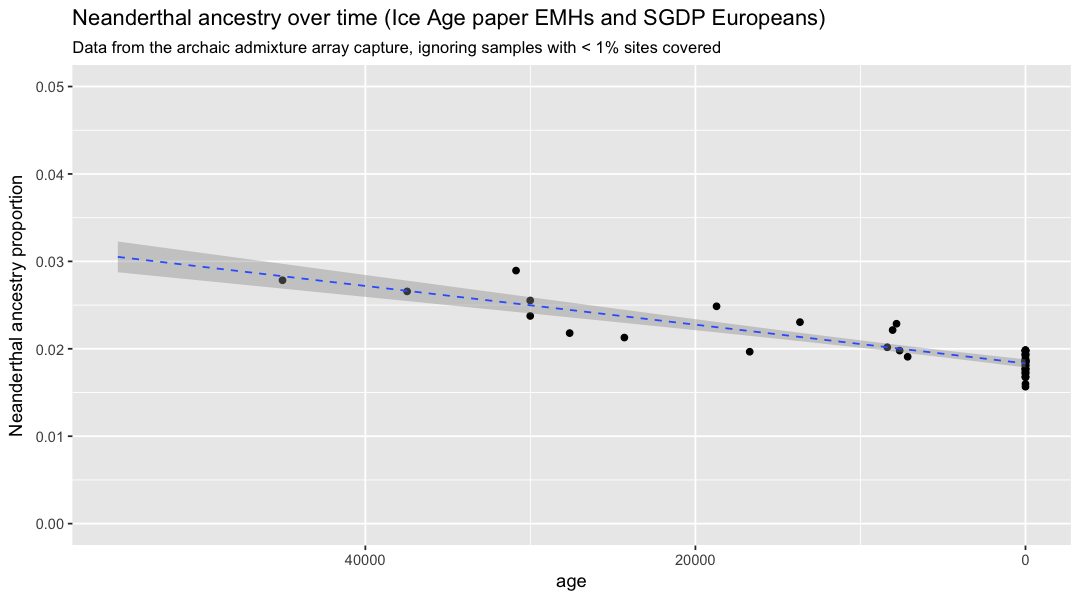

In [34]:
options(repr.plot.width=9, repr.plot.height=5)

############################################################
# plot the comparison of f4 and direct Nea. estimates
# 
# # comparison of f4 vs direct Nea. estimates
# ggplot(nea_wide, aes(f4, direct)) +
#     geom_point() +
#     geom_smooth(method="lm", linetype=2, size=0.5) +
#     ggtitle("Correlation of Nea% estimates using f4 ratios or admixture array SNPs",
#             "f4 ratio = 1 - f4(YRI, Chimp; X, Altai) / f4(YRI, Chimp; Dinka, Altai)")
# 
# ggplot(nea_wide, aes(f4, direct, color=pop, group=pop)) +
#     geom_point() +
#     geom_smooth(method="lm", linetype=2, size=0.5) +
#     ggtitle("Correlation of Nea% estimates using f4 ratios or admixture array SNPs",
#             "f4 ratio = 1 - f4(YRI, Chimp; X, Altai) / f4(YRI, Chimp; Dinka, Altai)")
# 
# ggplot(filter(nea_wide, pop != "EMH"), aes(f4, direct, color=pop, group=pop)) +
#     geom_point() +
#     geom_smooth(method="lm", linetype=2, size=0.5) +
#     ggtitle("Correlation of Nea% estimates using f4 ratios or admixture array SNPs",
#             "f4 ratio = 1 - f4(YRI, Chimp; X, Altai) / f4(YRI, Chimp; Dinka, Altai)")

crappy_samples <- names(keep(missing_snps, ~ .x > 0.99))
# Nea over time in West Eurasians
filter(nea_long, pop %in% c("EMH", "WestEurasia"), method == "direct", !name %in% c(non_udg_samples, crappy_samples)) %>%
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm", linetype=2, fullrange=TRUE, size=0.5) +
    xlim(55000, 0) + ylim(0, 0.05) +
    labs(y="Neanderthal ancestry proportion") +
    ggtitle("Neanderthal ancestry over time (Ice Age paper EMHs and SGDP Europeans)",
            subtitle="Data from the archaic admixture array capture, ignoring samples with < 1% sites covered")
# 
# # Nea over time in West Eurasians
# filter(nea_long, pop %in% c("EMH", "WestEurasia"), method == "f4") %>%
# ggplot(aes(age, alpha)) +
#     geom_point() +
#     geom_smooth(method="lm", linetype=2, fullrange=TRUE, size=0.5) +
#     facet_grid(method ~ .) +
#     xlim(55000, 0) + ylim(0, 0.1) +
#     ggtitle("Nea% (alpha) over time using Ice Age paper EMHs and SGDP West Eurasians",
#             "Upper panel - Nea. estimates using admixture array SNPs, bottom panel - ratio of f4 statistics")

Negative selection against Neanderthal introgression is currently widely accepted as an explanation for this decline. However, after testing of previously proposed models of selection against introgression (mainly selection against Neanderthal variants that accumulated in the Neanderthal population due to their low $N_e$) we find that these models cannot produce the continuous decline in Neanderthal ancestry observed in the real data.

There are at least two possible alternative explanations. One is a more complex selection model, perhaps some form of negative epistasis (this is what we are currently investigating). The second model involves a dilution of Neanderthal ancestry during part of the last 55 thousand years.

Several earlier studies indicate that a simple dilution scenario is not entirely implausible:

1. European individuals seem to carry various proportions of ancestry from three ancestral populations, one of them being a mysterious "basal Eurasian" population. [@lazaridis_ancient_2014]
2. Ancient modern human samples from the Upper Palaeolithic Europe show (beginning around 14ky) affinity towards present-day Near East populations. [@fu_genetic_2016]
3. Ancient Near East individuals derive part of their ancestry from the basal Eurasian population, which appears to have had much lower amounts of Neanderthal ancestry than any ancient or present-day modern human. [@lazaridis_genomic_2016]. If the ancient Near Easterners experienced dilution of their Neanderthal ancestry and they also admixed with EMHs in Europe, it follows that Neanderthal ancestry in Europeans was diluted as well.

This notebook contains a very simple exploratory analysis to evaluate whether this dilution hypothesis is possible.

# Testing the affinity towards the Near East using D statistic

We used an approach similar to the method used in the Ice Age paper [@fu_genetic_2016] (Supplementary note 11, page 59), but using the full set of EMH samples and also adding the present-day Europeans (which were missing in the @fu_genetic_2016 paper). Specifically, we calculated the following D statistic for each ancient or present-day European X:

$D(\textrm{Kostenki14}, \textrm{X}; \textrm{present-day Near East or East/South Asia or America}, \textrm{Mbuti})$,

which tests whether a given individual X shares more alleles with some of the present-day human populations than with an ancient hunter gatherer Kostenki 14.

Prepare the list of populations used in the rest of our analysis:

In [14]:
present_day_Y <- list(
    "near_east"=filter(samples, str_detect(name, "Iran|Jew|Jordan|Samaritan|Druze|Turkish|Bedouin|Palestinian"))$name,
    "america"=filter(samples, pop=="America")$name,
    "east_asia"=sample(filter(samples, pop=="EastAsia")$name, 10),
    "south_asia"=sample(filter(samples, pop=="SouthAsia")$name, 10),
    "central_asia_siberia"=sample(filter(samples, pop=="CentralAsiaSiberia")$name, 10)
)
ancient_X <- filter(emhs, !name %in% c("UstIshim", "Kostenki14"))$name
modern_X <- filter(samples, pop == "WestEurasia", !name %in% present_day_Y[["near_east"]])$name

Calculate the D statistics above for each present-day SGDP population:

In [15]:
# calculate the affinities of a set of ancient and modern Europeans to
# various present-day populations
affinity_dstats <- vector(mode = "list")
for (pop in names(present_day_Y)) {
    Y <- present_day_Y[[pop]]

    # calculate D statistics on the ancient individuals
    prefix_ancient <- paste0("affinity_", pop, "_dstats_ancient")
    create_Dstats_pops(W="Kostenki14", X=ancient_X, Y=Y, Z="Mbuti", file=paste0(prefix_ancient, ".pop"))
    create_param_file(
        param_file=paste0(prefix_ancient, ".par"),
        pops_file=paste0(prefix_ancient, ".pop"),
        eigenstrat_prefix="UPA_all",
        badsnp_file="UPA_all.transitions.snp"
    )
    run_cmd("qpDstat", param_file=paste0(prefix_ancient, ".par"), log_file=paste0(prefix_ancient, ".log"))

    # calculate D statistics on the modern individuals
    prefix_modern <- paste0("affinity_", pop, "_dstats_modern")
    create_Dstats_pops(W="Kostenki14", X=modern_X, Y=Y, Z="Mbuti", file=paste0(prefix_modern, ".pop"))
    create_param_file(
        param_file=paste0(prefix_modern, ".par"),
        pops_file=paste0(prefix_modern, ".pop"),
        eigenstrat_prefix="UPA_all",
        badsnp_file="UPA_all.transitions.snp"
    )
    run_cmd("qpDstat", param_file=paste0(prefix_modern, ".par"), log_file=paste0(prefix_modern, ".log"))
    
    affinity_dstats[[pop]] <- bind_rows(read_qpDstat(paste0(prefix_ancient, ".log")),
                                        read_qpDstat(paste0(prefix_modern, ".log"))) %>%
        mutate(affinity_to=pop)
}

# this took forever to run, so save the intermediate result
save(affinity_dstats, file="../RData/affinity.RData")

Joining, by = "name"


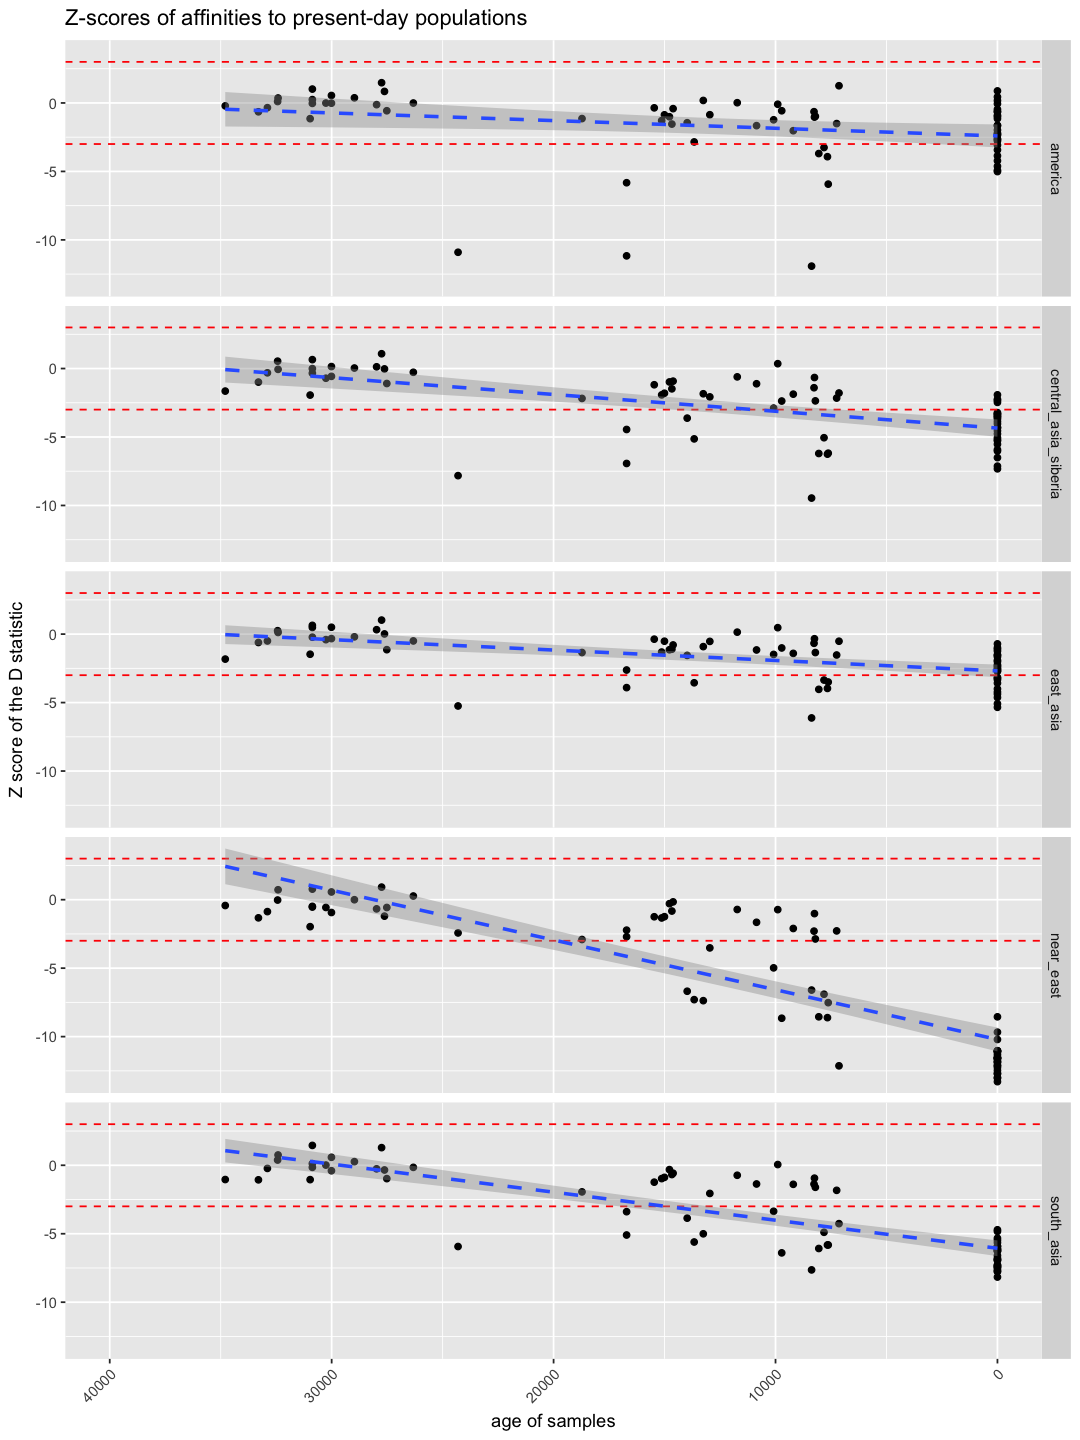

In [20]:
options(repr.plot.width=9, repr.plot.height=12)

load("../RData/affinity.RData")

## join Dstat results for ancient and present-day humans
affinity_dstats <- bind_rows(affinity_dstats) %>% mutate(name=X) %>% inner_join(samples)

## Dstats with Near east over time until present
affinity_dstats %>%
    group_by(name, age, affinity_to, pop) %>% summarise(Dstat=mean(Dstat), Zscore=mean(Zscore)) %>%
    ggplot(aes(age, Zscore)) +
    geom_point() +
    geom_hline(yintercept=c(3, -3), linetype=2, color="red", size=0.5) +
    geom_smooth(method="lm", linetype=2) + 
    xlim(40000, 0) +
    labs(x="age of samples", y="Z score of the D statistic") +
    facet_grid(affinity_to ~ .) +
    ggtitle("Z-scores of affinities to present-day populations") +
    theme(axis.text.x=element_text(angle=45, hjust=1))

Several observations:

1. Affinity of later early modern humans to the present-day Near East populations, but no change in affinity towards Americans and East Asians (already described by @fu_genetic_2016)

2. __The affinity towards Near East continues to be even stronger going to the present.__ 

3. __South Asia shows a similar trend as the Near East.__

4. It seems that there might be some partitioning in the samples between 15-10ky - almost as if only a subset of samples had a significant Near East ancestry, but others did not.

## Estimating the proportions of Near East and basal Eurasian ancestry

D statistic such as the one used above can be used as a significance test of potential admixture, but does not reveal the actual admixture _proportions_. Therefore, after finding a suggestive evidence of a growing affinity towards Near East, we were interested if there is also an increasing proportion of Near East ancestry (and potentially towards basal Eurasian ancestry?) over time until the present.

We did this by estimating:

1. The proportion of Near East ancestry in each EMH and present-day SGDP European (which should give us an idea about the rate of dilution that potentially happened).

2. The proportion of basal Eurasian ancestry directly.

### 1. Near East admixture proportion over time

To get an estimate of the Near East ancestry in an individual X, we used the following f4 ratio: $\frac{f_4(\textrm{present-day Near East},\textrm{ Mbuti}; \textrm{ test individual X},\textrm{ Vestonice 16})}{f_4(\textrm{present-day Near East},\textrm{ Mbuti};\textrm{ ancient Near East},\textrm{ Vestonice16})}$

In a terminology used by an f4 ratio scheme by @patterson_ancient_2012:

* A = subset of present-day Near Easterners from the SGDP panel
* B' = subset of ancient Near Easterners from @lazaridis_genomic_2016 (Levant and Natufians, 8-12ky old)
* C' = Vestonice16, 20ky old European without basal Eurasian ancestry
* O = Mbuti
* X = test individual.

![](img/f4ratios.png)

Merge ancient Near Eastern individuals into an "ancient_NearEast" metapopulation, do a similar thing with present-day Near Easterners.

In [22]:
merge <- list(
    ancient_NearEast=c("Levant_N", "Natufian"), 
    present_NearEast=c("Yemenite_Jew", "Jordan", "Samaritan", "Bedouin", "Palestinian")
)

In [24]:
merge_pops("UPA_all.ind", "UPA_all.ind.NearEast", merge)

Calculate the Near East $f4$ ratios:

In [25]:
prefix_ancient <- "near_east_proportion_ancient"
prefix_modern <- "near_east_proportion_modern"

In [26]:
# ancient humans
create_qpF4ratio_pops(X=ancient_X,
                   A="present_NearEast", B="ancient_NearEast", C="Vestonice16", O="Mbuti",
                   file=paste0(prefix_ancient, ".pop"))
create_param_file(paste0(prefix_ancient, ".par"),
               paste0(prefix_ancient, ".pop"),
               geno_file="UPA_all.geno",
               snp_file="UPA_all.snp",
               ind_file="UPA_all.ind.NearEast",  
               badsnp_file="UPA_all.transitions.snp")
run_cmd("qpF4ratio",
     param_file=paste0(prefix_ancient, ".par"),
     log_file=paste0(prefix_ancient, ".log"))

## modern humans
create_qpF4ratio_pops(X=modern_X,
                   A="present_NearEast", B="ancient_NearEast", C="Vestonice16", O="Mbuti",
                   file=paste0(prefix_modern, ".pop"))
create_param_file(paste0(prefix_modern, ".par"),
               paste0(prefix_modern, ".pop"),
               geno_file="UPA_all.geno",
               snp_file="UPA_all.snp",
               ind_file="UPA_all.ind.NearEast",
               badsnp_file="UPA_all.transitions.snp")
run_cmd("qpF4ratio",
     param_file=paste0(prefix_modern, ".par"),
     log_file=paste0(prefix_modern, ".log"))

Joining, by = "name"


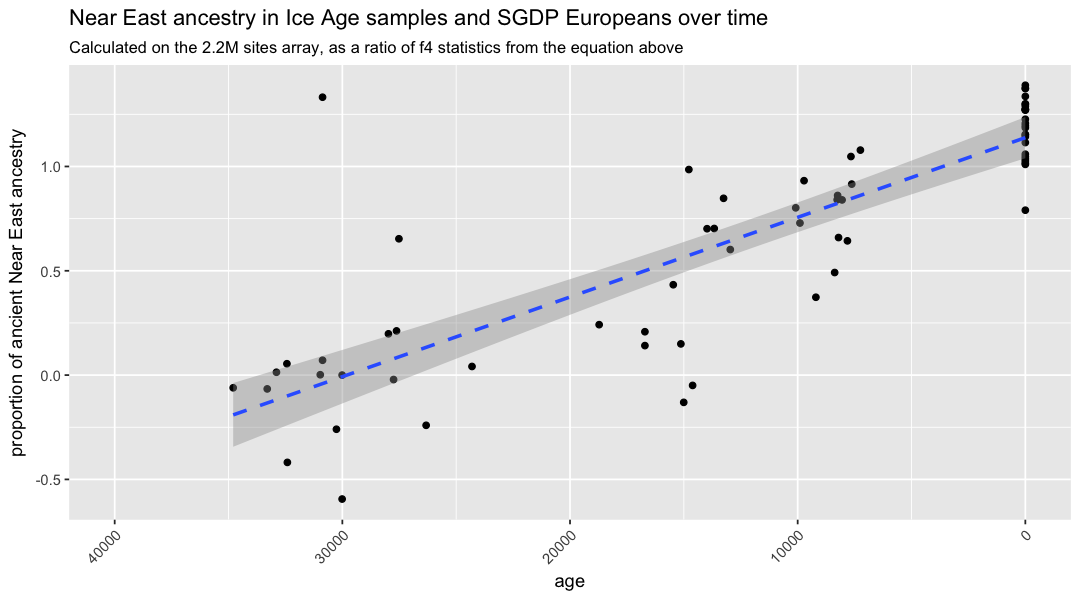

In [29]:
options(repr.plot.width=9, repr.plot.height=5)

near_east_proportion <-
    bind_rows(read_qpF4ratio(paste0(prefix_ancient, ".log")),
              read_qpF4ratio(paste0(prefix_modern, ".log"))) %>%
    rename(name=X) %>%
    inner_join(samples)


## F4 ratios of Near eastern ancestry in present-day and UP humans over time
near_east_proportion %>% filter(pop != "EMH" | abs(alpha) < 1.5) %>% 
    ggplot(aes(age, alpha)) +
    geom_point() + geom_smooth(method="lm", linetype=2) + 
    xlim(40000, 0) + labs(y="proportion of ancient Near East ancestry") +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    ggtitle("Near East ancestry in Ice Age samples and SGDP Europeans over time",
            subtitle="Calculated on the 2.2M sites array, as a ratio of f4 statistics from the equation above")

In agreement with the D statistics analysis above, this indicates that the proportion of Near Eastern ancestry in Europe:

* Is higher in later ancient samples compared to the earliest ones.
* __Is even higher for the present-day samples__, which suggests that the gene-flow from the Near East continued even during the last ~8 ky.

__Question__: Is there a better way to estimate the proportion of Near East ancestry?

Specifically, present-day humans show a slightly higher proportion of Near East ancestry than 1.0, which could be a sign of an imperfect phylogeny than the one shown in a diagram above. For example, if the population of Vestonice16 are not direct ancestors of present-day Europeans, this would lead to the underestimation of $1 - \alpha$ and, therefore, to the overestimation of $\alpha$ and to it's value above 1.0?

## 2. estimating the basal Eurasian ancestry

While the analysis above is informative about the rate of admixture from an ancient Near Eastern population (and, potentially, about the rate of dilution), it is not an estimate of the basal Eurasian ancestry over time.

To get a direct estimate of the basal Eurasian ancestry, we modified an approach applied in @lazaridis_genomic_2016 (Supplementary note page 23).

We used the following f4 ratio, which is informative about the proportion of basal Eurasian ancestry in an individual Test, described in the following figure (taken from @lazaridis_genomic_2016):

![](img/f4_basal.png)

In our case:

* A = Ust-Ishim, a 45ky old human (who split from present-day humans before the split of Europeans and Asians)

* B = Kostenki14, a 37ky old West Eurasian

* West Eurasian without basal Eurasian admixture = Vestonice 16, 20ky old European

* Test = one of the Ice Age or present-day SGDP Europeans whose basal Eurasian ancestry ($\alpha$) we want to estimate

* African = Mbuti.

In [30]:
calc_basal_alpha <- function(W_afr, W_ancient, W_modern, X, Y, Z, output) {
    ## denominator
    create_Dstats_pops(
        W=W_afr,
        X=X,
        Y=Y,
        Z=Z,
        file="basal_alpha_denominator.pop"
    )
    create_param_file(
        param_file="basal_alpha_denominator.par",
        pops_file="basal_alpha_denominator.pop",
        eigenstrat_prefix="UPA_all",
        badsnp_file="UPA_all.transitions.snp",
        f4mode=TRUE
    )
    run_cmd("qpDstat",
            param_file="basal_alpha_denominator.par",
            log_file=paste0(output, "_denominator.log"))
    
    ## ancient
    create_Dstats_pops(
        W=W_ancient,
        X=X,
        Y=Y,
        Z=Z,
        file="basal_alpha_ancient.pop"
    )
    create_param_file(
        param_file="basal_alpha_ancient.par",
        pops_file="basal_alpha_ancient.pop",
        eigenstrat_prefix="UPA_all",
        badsnp_file="UPA_all.transitions.snp",
        f4mode=TRUE
    )
    run_cmd("qpDstat",
            param_file="basal_alpha_ancient.par",
            log_file=paste0(output, "_ancient.log"))
    
    ## modern
    create_Dstats_pops(
        W=W_modern,
        X=X,
        Y=Y,
        Z=Z,
        file="basal_alpha_modern.pop"
    )
    create_param_file(
        param_file="basal_alpha_modern.par",
        pops_file="basal_alpha_modern.pop",
        eigenstrat_prefix="UPA_all",
        badsnp_file="UPA_all.transitions.snp",
        f4mode=TRUE
    )
    run_cmd("qpDstat",
            param_file="basal_alpha_modern.par",
            log_file=paste0(output, "_modern.log"))
}

read_basal_alpha <- function(output_prefix) {
    blah1 <- read_qpDstat(paste0(output_prefix, "_denominator.log"))
    blah2 <- bind_rows(read_qpDstat(paste0(output_prefix, "_ancient.log")),
                       read_qpDstat(paste0(output_prefix, "_modern.log")))
    
    ## calculate ratios blah2 / blah1
    basal_alpha <- mutate(blah2, alpha=Dstat/blah1$Dstat) %>%
        select(name=W, alpha) %>%
        left_join(samples) %>%
        mutate(name=factor(name, levels=name[order(alpha, decreasing=TRUE)]))
    
    basal_alpha
}

In [31]:
calc_basal_alpha(W_afr="Mbuti",
                 W_ancient=filter(samples, pop == "EMH",
                                           !name %in% c("UstIshim", "Kostenki14", "Oase1"))$name,
                 W_modern=filter(samples, pop == "WestEurasia")$name,
                 X="Vestonice16",
                 Y="UstIshim",
                 Z="Kostenki14",
                 output="basal_using_modified_lazaridis_setup")

Joining, by = "name"


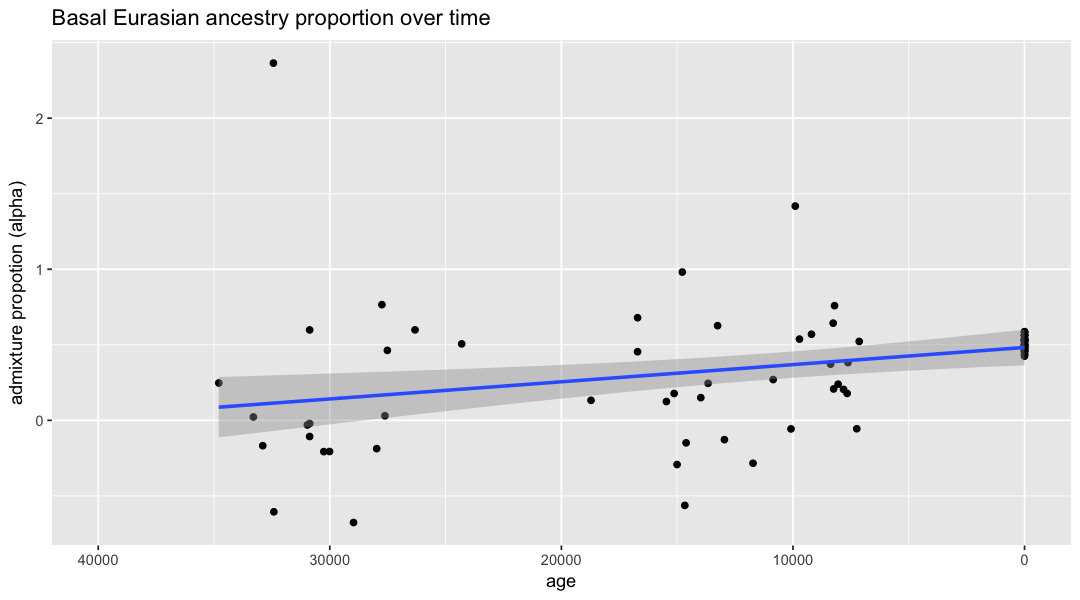

In [32]:
basal_alpha <- read_basal_alpha("basal_using_modified_lazaridis_setup")

## basal Eurasian proportion over time
ggplot(basal_alpha, aes(age, alpha)) +
    geom_point() +
    ggtitle("Basal Eurasian ancestry proportion over time") +
    labs(y="admixture propotion (alpha)") +
    geom_smooth(method="lm") +
    xlim(40000, 0)

This result is in agreement with the previous plots. Although the estimates are noisy, relative comparison of $\alpha$ across time indicates that the proportion of basal Eurasian ancestry has increased.